In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.transforms import Affine2D
from matplotlib.patches import ConnectionPatch

from PIL import Image

import skimage.io
import skimage.color
import skimage.exposure
from skimage.color import rgb2gray
from skimage.transform import rotate

import glob

# Data loader

In [41]:
def show_images(images, size=(10, 6), title=""):
    fig, axes = plt.subplots(1, len(images), figsize=size)
    for idx, image in enumerate(images):
        axes[idx].imshow(images)
    fig.suptitle(title, fontsize=12)
    plt.show()

In [42]:
def data_loader(path: str, appear: bool = False, show_size=(12, 6), title: str = ""):
    image_paths = sorted(glob.glob(path))
    images = [cv2.imread(path, cv2.IMREAD_UNCHANGED) for path in image_paths]
    if appear:
        show_images(images, show_size, title)
    return images

# Data cleaning

In [43]:
def normalize_images(images, appear: bool = False, title: str = ""):
    normal_images = [(image / np.max(image) * 255).astype(np.uint8) for image in images]
    if appear:
        show_images(normal_images, title=title)
    return normal_images

In [44]:
def to_gray_images(images, appear=False, title=""):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.shape == 3 else image
                   for image in images]
    if appear:
        show_images(gray_images, title=title)
    return gray_images

# Feature detector

In [45]:
def harris_corner_detector(images: list, block_size: int, k_size: int, k_harris_parameter=0.04, threshold=0.01,
                          appear=False):
    key_points = []
    for img in images:
        corner = cv2.cornerHarris(img, block_size, k_size, k_harris_parameter)
        corner = cv2.dilate(corner, None)

        points = np.argwhere(corner > threshold * corner.max())
        keypoint = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in points]

        key_points.append(keypoint)

    if appear:
        plot_key_points(images, key_points)

    return key_points

In [46]:
def plot_key_points(images, key_points):
    _, axes = plt.subplots(1, len(images), figsize=(10, 6))
    for idx, image in enumerate(images):
        points = np.array([list(keypoint.pt) for keypoint in key_points[idx]])
        axes[idx].imshow(image)
        axes[idx].scatter(points[:, 0], points[:, 1], marker='x', color='r')
    plt.show()

# Image matching

In [47]:
def matching_images(gray_images, key_points, num_top_matches=50, appear=False):
    sift = cv2.SIFT_create()

    #src image
    gray_src = gray_images[0]
    src_key_points = key_points[0]

    # des image
    gray_des = gray_images[1]
    des_key_points = key_points[1]

    # Detect descriptors using SIFT
    src_key_points, src_descriptors = sift.compute(gray_src, src_key_points)
    des_key_points, des_descriptors = sift.compute(gray_des, des_key_points)

    # Match descriptors using FLANN matcher
    matcher = cv2.FlannBasedMatcher()
    matches = matcher.match(src_descriptors, des_descriptors)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Select top matches
    matches = matches[:num_top_matches]

    # Extract matched keypoints
    src_points = np.float32([src_key_points[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    des_points = np.float32([des_key_points[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    if appear:
        plot_matches(gray_src, gray_des, src_points, des_points)

    return src_points, des_points

In [48]:
# use this function to visualize the matches
def plot_matches(src_img, des_img, src_points, des_points):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # draw images
    axes[0].imshow(src_img)
    axes[1].imshow(des_img)

    # draw matches
    for src_point, des_point in zip(src_points, des_points):
        kp1, kp2 = src_point[0], des_point[0]

        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color='r')
        fig.add_artist(con)
        axes[0].plot(*kp1, color='r', marker='x')
        axes[1].plot(*kp2, color='r', marker='x')

    plt.show()

# Global alignment

# Blending and Compositing

In [49]:
def warpTwoImages(img_src, img_des, H, appear=False):
    # Warp the source image to align with the destination image 
    h1, w1 = img_src.shape[:2]
    h2, w2 = img_des.shape[:2]

    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    wrap_src_img = cv2.warpPerspective(img_src, Ht.dot(H), (xmax - xmin, ymax - ymin))
    plt.imshow(wrap_src_img)
    plt.title('Wrap')
    plt.show()

    # Combine the two images into a panorama
    wrap_src_img[t[1]:h2 + t[1], t[0]:w2 + t[0]] = img_des

    if appear:
        plt.imshow(wrap_src_img)
        plt.title('Panorama result')
        plt.show()

    return wrap_src_img  #%%

## Main function

In [50]:
def stitching_images_harris_test(img_src, img_des):
    # Normalize values, change data type
    imgs_norm_uint8 = normalize_images([img_src, img_des], title="Nomalized images")

    # Grayscale images
    gray_imgs = to_gray_images(imgs_norm_uint8)

    # Harris conner detector
    keypoints = harris_corner_detector(gray_imgs,
                                       block_size=2,
                                       k_size=3,
                                       k_harris_parameter=0.04,
                                       threshold=0.01,
                                       appear=False)

    # Matching images, because there are only two images for testing => only one patched points
    src_points, des_points = matching_images(gray_imgs, keypoints,
                                                num_top_matches=50,
                                                appear=False)

    # Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(src_points, des_points, cv2.RANSAC, 10.0)

    # Find the size of new panorama
    panorama = warpTwoImages(img_src, img_des, H, appear=True)

    return panorama

# HARRIS_IMAGE_RESULT = stitching_images_harris_test()

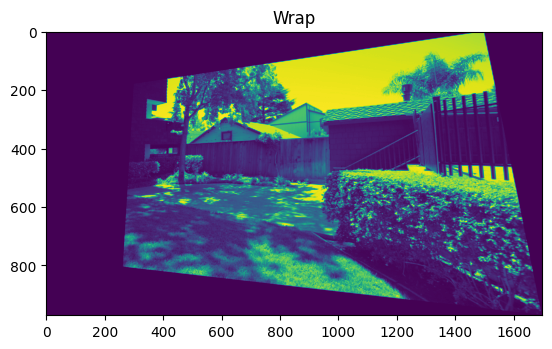

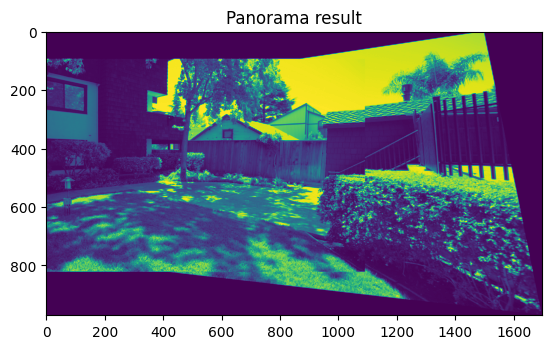

In [51]:
def multi_panorama():
    # Load images. CV2 reads in BGR format
    imgs = data_loader('data/yard/*.png')[:2]

    firs_images = imgs[0]
    for i in range(1, len(imgs)):
        new_firs_images = stitching_images_harris_test(firs_images, imgs[i])

        firs_images = new_firs_images.copy()
    return firs_images

panorama = multi_panorama()


# Output

In [52]:
### General code structure

def stitching_images(img_src: np.array, img_des: np.array):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch

    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

    return [combined_image, Harris, num_inliers, residual]#%% md
## Main function